# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import networkx as nx
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import clone
from sklearn.metrics.pairwise import cosine_similarity
from math_placement_model import *
import pickle
import warnings

## Data Paths

<b> NOTE: </b>

<b> Placement test data </b> as input to the model must be in a csv file that has <i>exactly</i> the following columns:
1. Student
2. Currently in
3. Columns in the form: skill_questionum_level
- Where skill is one of [num_ops, quad, func, geom, alg_exp, expn, linear]
- Where questionum is an integer
- Where level is an integer from 1-3.

<b> IB results data </b> to be added to the training set must be in a csv file that has <i>at least</i> the following columns:
1. 'Year'
2. 'Subject'
3. 'Level'
4. 'Grade'

In [2]:
#Pathway to training data.
X_TRAIN_PATH = 'X_train_10_6.pkl'
Y_TRAIN_PATH = 'y_train_10_6.pkl'

#Pathway to untrained model with parameters.
BASE_MODEL_UNTRAINED_PATH = 'base_model_untrained_10_6.pkl'

In [3]:
#Loading training data.
X_train = pickle.load(open(X_TRAIN_PATH, 'rb'))
y_train = pickle.load(open(Y_TRAIN_PATH, 'rb'))

In [4]:
#Load pre-trained model
PRE_TRAINED_MODEL_PATH = 'math_prediction_model_11_06.pkl'

In [5]:
# UPDATE_TRAIN is set to false by default. 
#If set to True, the model will retrain on a larger dataset. 
UPDATE_TRAIN = False

In [6]:
# You must add the pathway to the additional training data that you want to add to the model.
# Fill in the fields that are commented out below.
if UPDATE_TRAIN:
    ADD_RAW_X_TRAIN_PATH = ''#insert file name of additional training data (placement scores)''
    ADD_RAW_Y_TRAIN_PATH = ''#insert file name of additional training data (IB results)''
    BASE_MODEL_UNTRAINED_PATH = 'base_model_untrained_10_6.pkl'
    DATE = ''#fill in with current date.

In [7]:
#NOTE: This data was used in developing the model. 
#It is included only for demonstration of notebook functionality.
RAW_TEST_PATH = 'placement_scores_no_names_2021.csv'

# Prepare Training/Testing Data

In [8]:
df_transformer = prepare_clean_df(X_train, y_train)

if UPDATE_TRAIN:
    #Add training data to the existing training data.
    X_train_upd, y_train_upd = df_transformer.transform(x_file_path = ADD_RAW_X_TRAIN_PATH, 
                                                      y_file_path = ADD_RAW_Y_TRAIN_PATH,
                                                      train_test = 'train')
    #Pickle the new training data and save with the current date.
    pickle.dump(X_train_upd,open('X_train_' + DATE + '.pkl', 'wb'))
    pickle.dump(y_train_upd,open('y_train_' + DATE + '.pkl', 'wb'))

#Import and clean the testing data.
X_test = df_transformer.transform(x_file_path = RAW_TEST_PATH, 
                                        train_test = 'test')

# The model

## Load Model

In [9]:
if UPDATE_TRAIN:
    # Print results of original model.
    base_model = pickle.load(open(BASE_MODEL_UNTRAINED_PATH, 'rb'))
    print('Pre-trained model:\n')
    cross_validate_model(base_model, X_train, y_train, scorer = 'f1_weighted', plot = False)  
    #Print results of model on updated data.
    print('\n\nUpdated model:\n')
    cross_validate_model(base_model, X_train_upd, y_train_upd, scorer = 'f1_weighted')
    #Train the model on the updated data.
    base_model =  pickle.load(open(BASE_MODEL_UNTRAINED_PATH, 'rb')) 
    mp_prediction = math_placement_prediction_model(base_model)
    mp_prediction.fit(X_train_upd, y_train_upd)
    pickle.dump(mp_prediction, open('math_prediction_model_' + DATE + '.pkl', 'wb'))

else:
    mp_prediction = pickle.load(open(PRE_TRAINED_MODEL_PATH, 'rb'))

## Run Model

88.68% of the predictions were predicted with probability above 0.5.


47.17% of the lower boundaries of the confidence intervals had probabilities above 0.5.




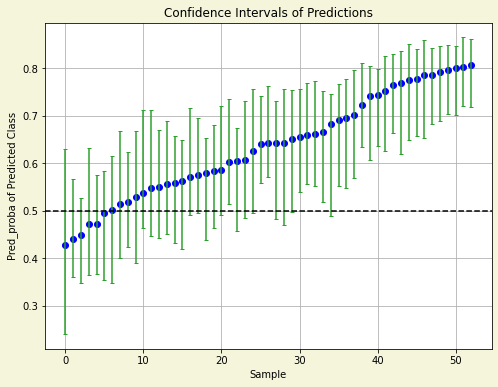

In [10]:
predictions = mp_prediction.predict(X_test, c_i=80)

In [11]:
predictions.head(2)

,pred_prob,lower_ci_val,upper_ci_val,pred_label,lower_conf_label
Student,,,,,
Student 139,0.643581,0.471125,0.755751,Math AA HL,Math AA HL
Student 140,0.602492,0.514949,0.735743,Math AA HL,Math AA HL


## Confidence Intervals Widget by Student Name

### Actual Widget

In [12]:
#Confidence intervals by student name.
mp_prediction.c_i_widget()

interactive(children=(Dropdown(description='idx', options=('Student 139', 'Student 140', 'Student 141', 'Stude…

### Sample output (widget only available when running jupyter)

<img src="ci_widget_sample.png" alt="drawing" width="320"/>

## Email Widget by Student Name

### Actual Widget

In [13]:
#Email widget takes the path to the raw test data, and the 
#predictions from the confidence interval model and outputs an email to the student.
email_widget(raw_test_path = RAW_TEST_PATH, ci_predictions = predictions)

interactive(children=(Dropdown(description='idx', options=('Student 139', 'Student 140', 'Student 141', 'Stude…

### Sample output (widget only available when running jupyter)

<b>Example #1:</b>

<img src="email_sample_1.png" alt="drawing" width="300"/>

<b> Example #2: </b>

<img src="email_sample_2.png" alt="drawing" width="600"/>